In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
loja = pd.read_csv('01-dados/04-lojas.csv')
treino = pd.read_csv('01-dados/04-dataset_treino.csv', low_memory=False)
teste = pd.read_csv('01-dados/04-dataset_teste.csv', low_memory=False)

In [3]:
loja.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
treino.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
teste.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
data = treino.merge(loja, on='Store')

In [7]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


# Time Intelligence

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data['Dia'] = data['Date'].dt.day
data['Mes'] = data['Date'].dt.month
data['Semana_Ano'] = data['Date'].dt.weekofyear
data['Ano'] = data['Date'].dt.year
data['Inicio_Dia'] = data['Date'].dt.is_month_start
data['Ultimo_Dia'] = data['Date'].dt.is_month_end
data['Inicio_Trimestre'] = data['Date'].dt.is_quarter_start
data['Fim_Trimestre'] = data['Date'].dt.is_quarter_end
data['Ano_Inicio'] = data['Date'].dt.is_year_start
data['Ano_Fim'] = data['Date'].dt.is_year_end

In [9]:
colunas = []
for f in data.columns.drop('Sales'):
    if data[f].dtype == np.float64 or data[f].dtype == np.int64:
        colunas.append(f)

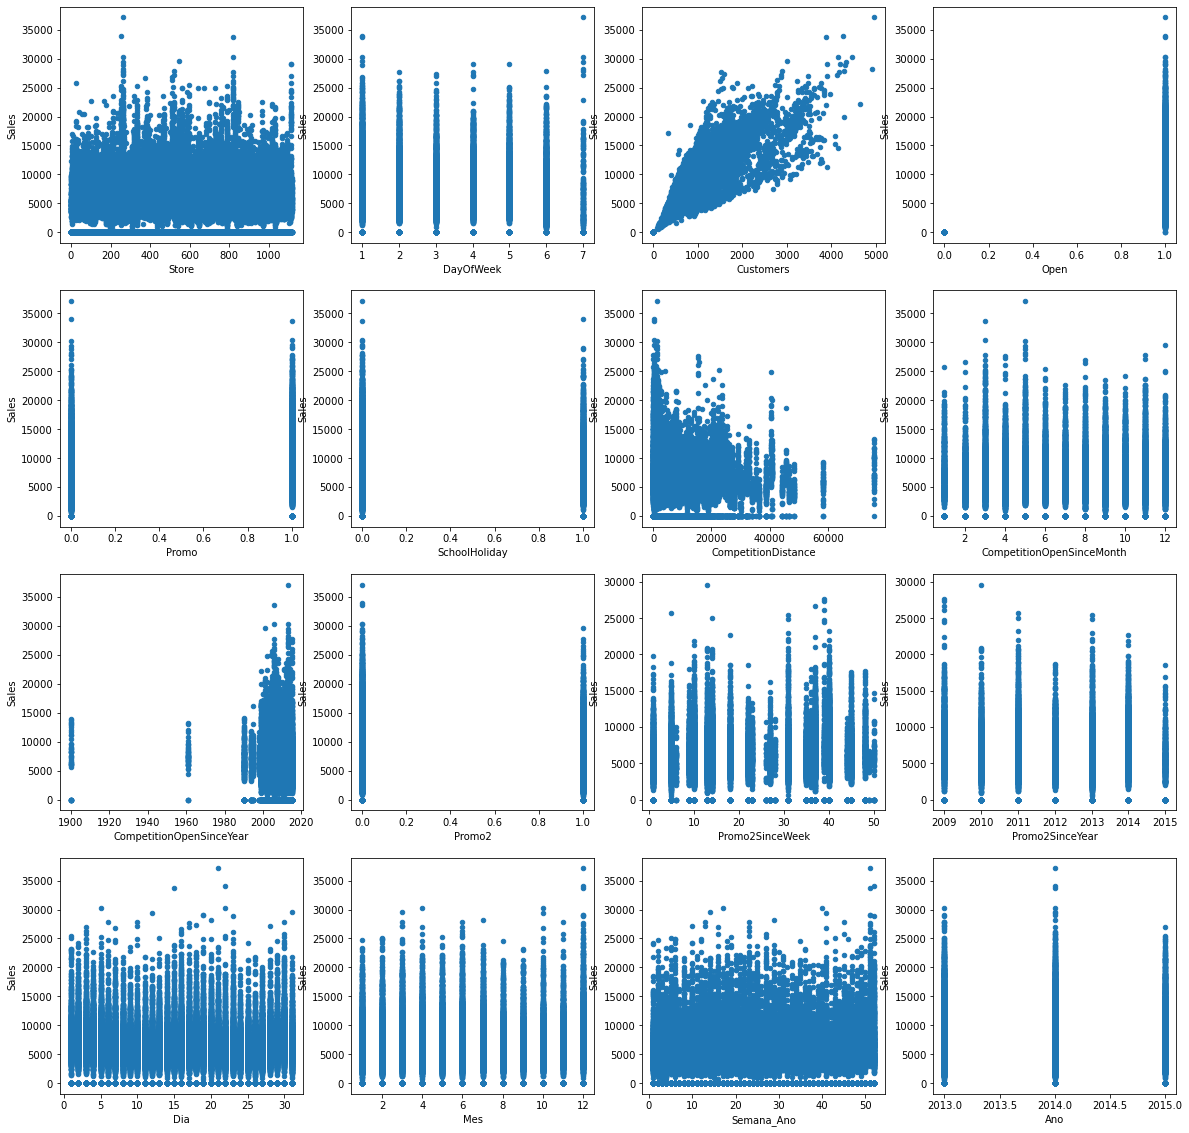

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
amostra = data.sample(frac=0.05)

for i, c in enumerate(colunas):
    amostra.plot(c, "Sales", subplots=True, kind="scatter", ax=ax[i // 4, i % 4])

In [11]:
del amostra

In [12]:
data[data.columns.drop('Sales')].corrwith(data.Sales)

Store                        0.005126
DayOfWeek                   -0.462125
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
CompetitionDistance         -0.019229
CompetitionOpenSinceMonth   -0.028257
CompetitionOpenSinceYear     0.012659
Promo2                      -0.091040
Promo2SinceWeek              0.059558
Promo2SinceYear             -0.021127
Dia                         -0.011612
Mes                          0.048768
Semana_Ano                   0.052946
Ano                          0.023519
Inicio_Dia                  -0.053450
Ultimo_Dia                   0.047112
Inicio_Trimestre            -0.013222
Fim_Trimestre                0.027899
Ano_Inicio                  -0.084589
Ano_Fim                     -0.019392
dtype: float64

In [13]:
data.groupby('StoreType')['Sales'].mean()

StoreType
a     5738.179710
b    10058.837334
c     5723.629246
d     5641.819243
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Sales', ylabel='Density'>

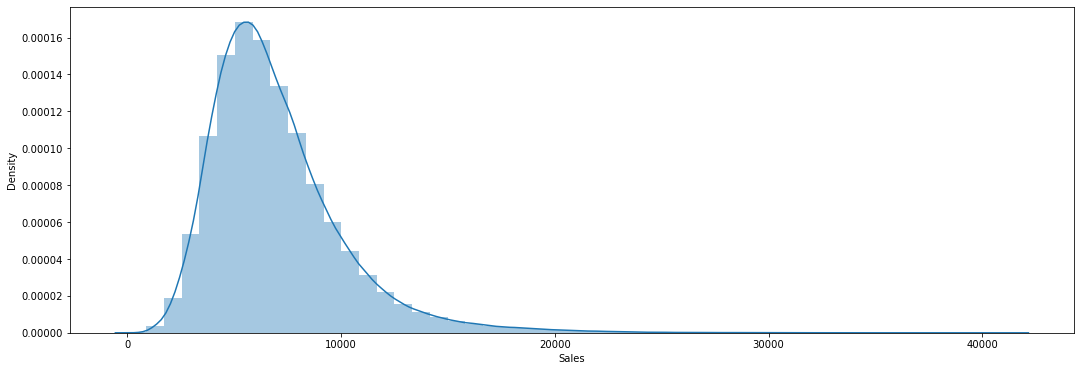

In [14]:
plt.figure(figsize=(18,6))
sns.distplot(data.Sales[data.Sales >0])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

# Dados Missing

In [16]:
# Porcentagem dos Dados Missing
(data.isnull().sum()/len(data)*100).sort_values(ascending=False)

PromoInterval                49.943620
Promo2SinceYear              49.943620
Promo2SinceWeek              49.943620
CompetitionOpenSinceYear     31.787764
CompetitionOpenSinceMonth    31.787764
CompetitionDistance           0.259730
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
Ano_Fim                       0.000000
Ano_Inicio                    0.000000
Promo2                        0.000000
Dia                           0.000000
Mes                           0.000000
Semana_Ano                    0.000000
Ano                           0.000000
Inicio_Dia                    0.000000
Ultimo_Dia                    0.000000
Inicio_Trimestre         

In [17]:
# Tratando os valorses ausentes
data['CompetitionOpenSinceYear'].fillna(0, inplace=True)
data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
data['Promo2SinceWeek'].fillna(0, inplace=True)
data['Promo2SinceYear'].fillna(0, inplace=True)
data['CompetitionDistance'].fillna(data['CompetitionDistance'].median(), inplace=True)
data['CompetitionDistance'] = np.log(data.CompetitionDistance) + 1

In [18]:
# Tratando os feriados
data['StateHoliday'] = data['StateHoliday'].replace(0, '0')
data['Feriado'] = data.StateHoliday.apply(lambda x: 0 if x == '0' else 1)
data.drop('StateHoliday', axis=1, inplace=True)

In [19]:
# Ordenando o dataset
data = data.sort_values(by='Date')
data.drop('Date',axis=1, inplace=True)

In [20]:
# Separando as lojas abertas
data = data[(data['Open'] != 0) & (data['Sales'] != 0)]
data.drop('Open', axis=1, inplace=True)

In [21]:
# Contagem de promoções 
data.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     242397
Feb,May,Aug,Nov      97998
Mar,Jun,Sept,Dec     80651
Name: PromoInterval, dtype: int64

In [22]:
data['Competicao_Aberta'] = 12 * (data.Ano - data.CompetitionOpenSinceYear) + (data.Mes - data.CompetitionOpenSinceMonth)
    
data['Promocao_Aberta'] = 12 * (data.Ano - data.Promo2SinceYear) + (data.Semana_Ano - data.Promo2SinceWeek) / 4.0

data = pd.get_dummies(data, columns=['DayOfWeek','StoreType', 'Assortment','PromoInterval'], dummy_na=True)

# Repetindo os procedimentos para os dados de teste

In [23]:
teste.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [24]:
teste = pd.read_csv('01-dados/04-dataset_teste.csv', low_memory=False)


teste = teste.merge(loja, on='Store')

teste['Date'] = pd.to_datetime(teste['Date'])
teste['Dia'] = teste['Date'].dt.day
teste['Mes'] = teste['Date'].dt.month
teste['Semana_Ano'] = teste['Date'].dt.weekofyear
teste['Ano'] = teste['Date'].dt.year
teste['Inicio_Dia'] = teste['Date'].dt.is_month_start
teste['Ultimo_Dia'] = teste['Date'].dt.is_month_end
teste['Inicio_Trimestre'] = teste['Date'].dt.is_quarter_start
teste['Fim_Trimestre'] = teste['Date'].dt.is_quarter_end
teste['Ano_Inicio'] = teste['Date'].dt.is_year_start
teste['Ano_Fim'] = teste['Date'].dt.is_year_end

teste['CompetitionOpenSinceYear'].fillna(0, inplace=True)
teste['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
teste['Promo2SinceWeek'].fillna(0, inplace=True)
teste['Promo2SinceYear'].fillna(0, inplace=True)
teste['CompetitionDistance'].fillna(data['CompetitionDistance'].median(), inplace=True)
#teste['CompetitionDistance'] = np.log(data.CompetitionDistance) + 1

teste['StateHoliday'] = teste['StateHoliday'].replace(0, '0')
teste['Feriado'] = teste.StateHoliday.apply(lambda x: 0 if x == '0' else 1)
teste.drop('StateHoliday', axis=1, inplace=True)

#teste = teste.sort_values(by='Date')
teste.drop('Date',axis=1, inplace=True)

#teste = teste[(teste['Open'] != 0) & (teste['Sales'] != 0)]


teste['Competicao_Aberta'] = 12 * (teste.Ano - teste.CompetitionOpenSinceYear) + (teste.Mes - teste.CompetitionOpenSinceMonth)
teste['Promocao_Aberta'] = 12 * (teste.Ano - teste.Promo2SinceYear) + (teste.Semana_Ano - teste.Promo2SinceWeek) / 4.0

teste.drop('Open', axis=1, inplace=True)

teste = pd.get_dummies(teste, columns=['DayOfWeek','StoreType', 'Assortment','PromoInterval'], dummy_na=True)

In [25]:
x_train = data.drop(columns=['Sales','Store','Customers'])
y_train = data['Sales']

In [26]:
x_test = data.drop(columns=['Sales','Store','Customers'])
y_test = data['Sales']

In [27]:
treino = xgb.DMatrix(x_train, y_train)
teste = xgb.DMatrix(x_test, y_test)

params = {'n_estimators' : hp.quniform('n_estimators', 1, 1000, 1),
          'eta' : hp.quniform('eta', 0.2, 0.825, 0.025),
          'max_depth' : hp.choice('max_depth', np.arange(1, 14, dtype=int)),
          'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
          'subsample' : hp.quniform('subsample', 0.7, 1, 0.05),
          'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
          'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
          'eval_metric': 'rmse',
          'objective': 'reg:linear',
          'nthread': 4,
          'silent' : 1}

best_opts = {'colsample_bytree': 0.7, 
             'eta': 0.625, 
             'gamma': 0.8, 
             'max_depth': 6,
             'eval_metric': 'rmse',
             'min_child_weight': 6.0, 
             'n_estimators': 8.0,  # 585
             'silent': 1,
             'nthread': 4,
             'subsample': 0.95}

In [28]:
modelo = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [29]:
modelo.fit(x_train, y_train)

[07:26:06] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [30]:
prev = modelo.predict(x_test)

In [31]:
mean_squared_error(y_test, prev)

13466600.293034304